In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
import heapq
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing

## ID3

In [2]:
class Node(object):
    def __init__(self, className, value, entropy):
        self.className = className
        self.value = value
        self.entropy = entropy
        
        self.edges = {}
        

In [3]:
def ID3(data):
    
    if(data.empty):
        return None
    
    #If all examples are of one type, return that type
    if(len(data[data.columns[-1]].unique()) == 1):
        col = data[data.columns[-1]]
        return Node("target", data.iloc[0,-1], 0)
    
    #If only target column is left, return most frequent
    if(len(data.columns) == 1):
        return Node("target", data.iloc[:,-1].mode(), 0)
    
    #Run recursive algorithm
    minEntropyFeature = None
    bestFeature = None
    for column in data.columns[:-1]:
        
        featureEntropy = 0
        
        for value in data[column].unique():

            is_value = data[column] == value
            filtered = data[is_value]
            
            entropyOfValue = 0
            
            for outcome in filtered[filtered.columns[-1]].unique():
                is_outcome = filtered[filtered.columns[-1]] == outcome
                
                filteredOutcome = filtered[is_outcome]
                if(len(filteredOutcome) > 0): 
                    factor = len(filteredOutcome) / len(filtered)
                    entropyOfValue += -factor * math.log2(factor)
            
            featureEntropy += len(filtered) / len(data) * entropyOfValue
        
        if(minEntropyFeature is None or featureEntropy < minEntropyFeature):
            bestFeature = column
    
    #Construct node with best feature
    root = Node(bestFeature, None, minEntropyFeature)
    for value in data[bestFeature].unique():
        is_value = data[bestFeature] == value
        filtered = data[is_value].drop(bestFeature, axis=1)

        root.edges[value] = ID3(filtered)
    return root 

In [4]:
def BFS(root):
    queue = [[root, 0]]

    while(queue):
        [node, level] = queue.pop(0)
        print("LEVEL: ", level)
        print("NODE IS : ", node.className)
        if(node.className == "target"):
            print(node.value)
        else:
            print("KEYS : ", list(node.edges.keys()))
        for key in list(node.edges.keys()):
            queue.append([node.edges[key], level+1])
            
    

In [5]:
def evaluateIDModel(root, test, resultValues):
    
    correct = 0
    random = 0
    out = []
    for obs in test.values:

        iterator = root
        result = None
        while iterator.className != "target":
            
            key = iterator.className
            
            if(obs[key] in iterator.edges.keys()):
                iterator = iterator.edges[obs[key]]
            else:
                random += 1
                result = np.random.choice(resultValues)
                break
        
        if(iterator.className == "target"):
            
            if isinstance(iterator.value, pd.Series):
                result = np.random.choice(iterator.value) # It is random because sometimes there are two or more values with equal prob
            else:
                result = iterator.value 
        
        out.append(result)
        if(result == obs[-1]):
            correct += 1
    
    print("Accuracy is {}/{} = {} - {} observations were not in tree".format(correct, len(test), correct/ len(test), random))
    return out

In [6]:
def KNN(train_data, test_data, n):
    
    results = []
    
    for obs in test_data:
        dists = np.zeros(shape=len(train_data))
        
        for index in range(len(train_data)):
            x = train_data[index]
    
            for i in range(len(obs)-1):
                if(type(obs[i]) == type(1)):
                    dists[index] += abs(x[i] - test_data[i])
                elif(x[i] != obs[i]):
                    dists[index] += 1
                    
        topN = np.argpartition(dists,-n)[-n:]
        
        resultDic = {}
        for topNIndex in topN:
            if(train_data[topNIndex,-1] not in resultDic):
                resultDic[train_data[topNIndex,-1]] = 1
            else:
                resultDic[train_data[topNIndex,-1]] += 1
                
        nearestKey = None
        for key in resultDic:
            if(nearestKey is None or resultDic[key] > resultDic[nearestKey]):
                nearestKey = key
        
        results.append(nearestKey)
    return results

In [7]:
def evalResults(y_true, y_predicted):
    correctObs = 0
    for i in range(len(y_true)):
        if(y_true[i] == y_predicted[i]):
            correctObs += 1
    
    return correctObs / len(y_true)

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

postop
   0  1  2  3  4  5  6  7  8
0  2  1  0  2  0  1  1  3  0
1  2  0  0  0  0  1  1  2  2
2  0  1  0  0  0  1  0  2  0
3  2  1  1  0  0  2  0  3  0
4  2  2  0  0  0  1  1  2  0
Accuracy is 11/18 = 0.6111111111111112 - 1 observations were not in tree
0.5555555555555556
Normalized confusion matrix
[[0.83333333 0.         0.16666667]
 [1.         0.         0.        ]
 [0.75       0.         0.25      ]]


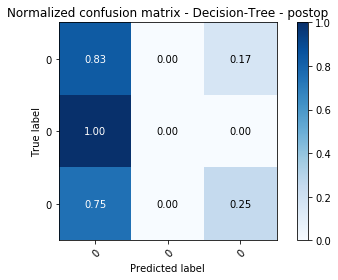

Normalized confusion matrix
[[0.83333333 0.         0.16666667]
 [1.         0.         0.        ]
 [1.         0.         0.        ]]


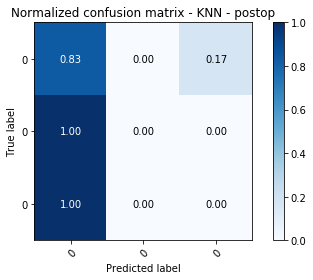

cmc
    0  1  2   3  4  5  6  7  8  9
0  24  2  3   3  1  1  2  3  0  1
1  45  1  3  10  1  1  3  4  0  1
2  43  2  3   7  1  1  3  4  0  1
3  42  3  2   9  1  1  3  3  0  1
4  36  3  3   8  1  1  3  2  0  1
Accuracy is 113/295 = 0.38305084745762713 - 131 observations were not in tree
0.34576271186440677
Normalized confusion matrix
[[0.44       0.256      0.304     ]
 [0.30769231 0.30769231 0.38461538]
 [0.39130435 0.23913043 0.36956522]]


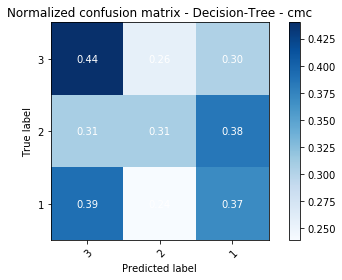

Normalized confusion matrix
[[0.632      0.112      0.256     ]
 [0.76923077 0.1025641  0.12820513]
 [0.68478261 0.15217391 0.16304348]]


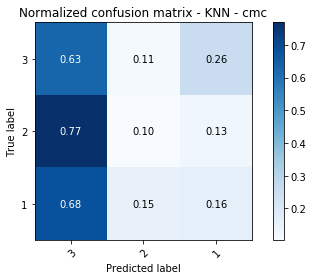

adult
   0   1       2   3   4   5   6   7   8   9     10  11  12  13  14
0  39   7   77516   9  13   4   1   1   4   1  2174   0  40  39   0
1  50   6   83311   9  13   2   4   0   4   1     0   0  13  39   0
2  38   4  215646  11   9   0   6   1   4   1     0   0  40  39   0
3  53   4  234721   1   7   2   6   0   2   1     0   0  40  39   0
4  28   4  338409   9  13   2  10   5   2   0     0   0  40   5   0
Accuracy is 10435/16281 = 0.6409311467354585 - 7797 observations were not in tree
0.4607825072170014
Normalized confusion matrix
[[0.73037791 0.26962209]
 [0.64331537 0.35668463]]


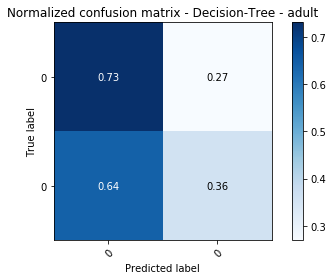

Normalized confusion matrix
[[0.56758721 0.43241279]
 [0.87862458 0.12137542]]


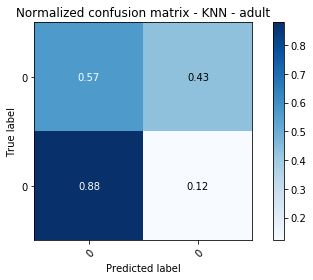

In [10]:

datasets = {
    "postop" : pd.read_csv("post-operative.data", header=None),
    "cmc" : pd.read_csv("cmc.data", header=None),
    "adult" : pd.read_csv("adult.data", header=None)
}

for key in datasets:
    
    dataset = datasets[key]
    

    # Ignore whitespace in obs
    for col in dataset.columns:
        if dataset[col].dtype == type(object):
            le = preprocessing.LabelEncoder()
            dataset[col] = dataset[col].str.strip()  
            dataset[col] = le.fit_transform(dataset[col])     
        
    print(key)
    print(dataset.head())
    resultValues = np.unique(dataset.values[:,-1])

    if(key == "adult"):
        train = datasets["adult"]
        test = pd.read_csv("adult.test", header=None)
        for col in test.columns:
            if test[col].dtype == type(object):
                le = preprocessing.LabelEncoder()
                test[col] = dataset[col].astype(str).str.strip()  
                test[col] = le.fit_transform(test[col])
    else:
        train, test = train_test_split(dataset, test_size=0.2)
    
    root = ID3(train)

    rID3 = evaluateIDModel(root, test, resultValues)
    
    rKNN = KNN(train.values, test.values, 10)
    print(evalResults(test.values[:,-1], rKNN))
    
    test_y = test.values[:,-1]

    plot_confusion_matrix(test_y, rID3, classes=test_y, normalize=True,
                      title='Normalized confusion matrix - Decision-Tree - {}'.format(key))
    plt.show()
    
    plot_confusion_matrix(test_y, rKNN, classes=test_y, normalize=True,
                      title='Normalized confusion matrix - KNN - {}'.format(key))
    plt.show()
